<a href="https://colab.research.google.com/github/mnocerino23/Wildfire-Forecaster/blob/main/Neural_Networks_set2_originalclasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this Jupyter Notebook, I attempt to train neural network multi-class classifiers on the smaller dataset (wildfire set 2) using the original class definitions in the kaggle dataset

Now that we have gathered data from kaggle, NOAA, the California Department of Water resources, and the Open-Elevation API into two consistent datasets, we will drop columns that are not necessary for training our models and take care of some final preprocessing.

In this file, I will build additional multi-class classifiers using Neural Networks in Tensorflow. 

The target feature will be ***Fire Size Class*** as we want to predict the size/risk of a large fire given certain weather and snow conditions.


I will deploy the following techniques:

1.   One-Hot Encoding of Categorical Variables
2.   Splitting the training and testing data
3.   Building the Neural Network in Tensorflow



In [146]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

#Read in the second final dataset. The second has 1,000 more recent, larger fires.
wildfire_set2 = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/Wildfires/wildfire_set2_w_allfeatures.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
wildfire_set2.head()

,Unnamed: 0,Year,Name,AcresBurned,Fire Size Rank,Cause,SOURCE_REPORTING_UNIT_NAME,DaysBurn,Discovery Month,Discovered DOY,...,DX90_2M,DP10_2M,Receives Snow,Snow Station,River Basin,Mar_SP,Mar_WC,Mar_Dens,Has_Elevation,Elevation
0,0,2016,Soberanes Fire,132127.0,G,NaN,NaN,83.0,Jul,NaN,...,0.0,1.0,0,NaN,NaN,0.0,0.0,0.00,1,961.2744
1,1,2016,Erskine Fire,48019.0,G,NaN,NaN,18.0,Jun,NaN,...,15.0,4.0,1,mineral_king,Kaweah,36.0,16.0,0.44,1,3389.0664
2,2,2016,Chimney Fire,46344.0,G,NaN,NaN,24.0,Aug,NaN,...,43.0,0.0,0,NaN,NaN,0.0,0.0,0.00,1,1049.8560
3,3,2016,Blue Cut Fire,36274.0,G,NaN,NaN,7.0,Aug,NaN,...,43.0,0.0,0,NaN,NaN,0.0,0.0,0.00,1,4192.8624
4,4,2016,Gap Fire,33867.0,G,NaN,NaN,1.0,Aug,NaN,...,0.0,2.0,1,parks_creek,Shasta,77.0,34.0,0.44,1,3244.7112


In [148]:
print(wildfire_set2.columns)

Index(['Unnamed: 0', 'Year', 'Name', 'AcresBurned', 'Fire Size Rank', 'Cause',
       'SOURCE_REPORTING_UNIT_NAME', 'DaysBurn', 'Discovery Month',
       'Discovered DOY', 'Contained Month', 'Contained DOY', 'Latitude',
       'Longitude', 'County', 'CountyIds', 'State', 'OWNER_DESCR',
       'NOAA Station', 'Link', 'AWND', 'CLDD', 'DP10', 'DX90', 'PRCP', 'TAVG',
       'TMAX', 'TMIN', 'PRCP_6M', 'PRCP_RS', 'DX90_2M', 'DP10_2M',
       'Receives Snow', 'Snow Station', 'River Basin', 'Mar_SP', 'Mar_WC',
       'Mar_Dens', 'Has_Elevation', 'Elevation'],
      dtype='object')


Drop all columns that will not be relevant for our classification task:Unnamed: 0, Year, Name, Cause, SOURCE_REPORTING UNIT NAME, DaysBurn, Discovered DOY, Contained Month, Contained DOY, Lat, Long, County Ids, State, OWNER_DESCR, NOAA Station, Link, Snow Station, River Basin

In [149]:
wildfire_set2.drop(columns = ['Unnamed: 0', 'Year', 'Name', 'Cause',
                      'SOURCE_REPORTING_UNIT_NAME', 'DaysBurn', 'Discovered DOY', 'Contained Month',
                      'Contained DOY','Latitude','Longitude','County','CountyIds','State','OWNER_DESCR',
                      'NOAA Station', 'Link', 'Snow Station', 'River Basin','Has_Elevation'], inplace = True)

Taking a look at the dataset after dropping columns:

In [150]:
wildfire_set2.head(5)

,AcresBurned,Fire Size Rank,Discovery Month,AWND,CLDD,DP10,DX90,PRCP,TAVG,TMAX,TMIN,PRCP_6M,PRCP_RS,DX90_2M,DP10_2M,Receives Snow,Mar_SP,Mar_WC,Mar_Dens,Elevation
0,132127.0,G,Jul,6.5,0.0,0.0,0.0,0.00,58.8,65.2,52.4,14.11,21.42,0.0,1.0,0,0.0,0.0,0.00,961.2744
1,48019.0,G,Jun,6.7,529.0,0.0,22.0,0.00,82.6,96.6,68.6,4.68,4.88,15.0,4.0,1,36.0,16.0,0.44,3389.0664
2,46344.0,G,Aug,6.9,237.0,0.0,23.0,0.00,72.6,92.6,52.6,2.52,8.09,43.0,0.0,0,0.0,0.0,0.00,1049.8560
3,36274.0,G,Aug,6.5,455.0,0.0,28.0,0.00,79.7,94.6,64.7,3.41,6.45,43.0,0.0,0,0.0,0.0,0.00,4192.8624
4,33867.0,G,Aug,4.5,0.0,0.0,0.0,0.02,56.4,62.9,49.9,18.03,54.17,0.0,2.0,1,77.0,34.0,0.44,3244.7112


In [151]:
wildfire_set2.shape

(1156, 20)

# Investigate the presence of null values in each dataset:
Below, we have the count of totall null values in each column for wildfire_set2.

In [152]:
print(wildfire_set2.isnull().sum())

AcresBurned         3
Fire Size Rank      0
Discovery Month     0
AWND               37
CLDD               37
DP10               32
DX90               34
PRCP               32
TAVG               37
TMAX               34
TMIN               37
PRCP_6M             7
PRCP_RS            10
DX90_2M             2
DP10_2M             1
Receives Snow       0
Mar_SP              0
Mar_WC              0
Mar_Dens            0
Elevation           0
dtype: int64


In [153]:
wildfire_set2 = wildfire_set2.dropna()

In the two cells above, we drop all null values in the dataset. We are able to drop all nulls in this case because our dataset has relatively few null values in each so not much data is lost in this process. Looking at the shape of the dataframe after the drops, we see that the dataset remains a similar size post drop.

In [154]:
wildfire_set2.shape

(1105, 20)

# In building this neural network, we will not modify classes to make them balanced. From attempting to do this previously, we found that the classifiers struggled to perform well potentially due to the classes being too arbitrary (they were selected in a way to make them balanced not necessarily in a way that makes their features easily distinguishable between one another). So we will try the original classes provided and see how the network performs

# A: 0-0.25 acres
# B=0.26-9.9 acres
# C=10.0-99.9 acres
# D=100-299 acres
# E=300 to 999 acres
# F=1000 to 4999 acres
# G=5000+ acres

As we can see below from the value counts for the Fire Size Rank column, the first dataset has an overwhelming amount of small wildfires from class A (0-0.25 acres) and class B (0.26-9.9), leading to a large imbalance in the first dataset.

In [155]:
print(wildfire_set2['Fire Size Rank'].value_counts())

C    559
D    222
E    111
F    101
G     92
A     18
B      2
Name: Fire Size Rank, dtype: int64


Restrict each dataset to wildfires larger than 10 acres since those smaller than that are not substantial and the goal of this project is to predict areas prone to destruction by wildfire




In [156]:
#wildfire2 = wildfire_set2
wildfire2 = wildfire_set2.loc[wildfire_set2['AcresBurned']> 10]

print(wildfire2['Fire Size Rank'].value_counts())

C    519
D    222
E    111
F    101
G     92
Name: Fire Size Rank, dtype: int64


We will start by using our larger dataset to build the neural network. If the network does not build a good classifier, we will experiment with the smaller dataset too.

# Histogram showing the count of each class within the first dataset (we will train on this data):

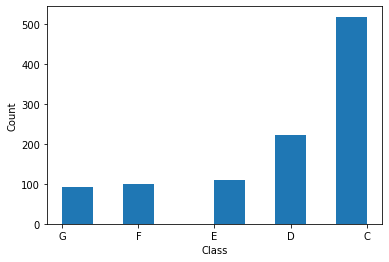

In [157]:
import matplotlib.pyplot as plt

x = wildfire2['Fire Size Rank']

plt.xlabel('Class')
plt.ylabel('Count')
plt.hist(x)
plt.show()

In [158]:
print(wildfire2.columns)
#print(wildfire2.columns)

Index(['AcresBurned', 'Fire Size Rank', 'Discovery Month', 'AWND', 'CLDD',
       'DP10', 'DX90', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'PRCP_6M', 'PRCP_RS',
       'DX90_2M', 'DP10_2M', 'Receives Snow', 'Mar_SP', 'Mar_WC', 'Mar_Dens',
       'Elevation'],
      dtype='object')


In [159]:
#After changing our class labels, we can delete the AcresBurned column in both dataframes since it
#will not be a feature we use.
wildfire2 = wildfire2.drop(columns = ['AcresBurned'], inplace = False)

#reset indexes to clean things up
wildfire2.reset_index()


,index,Fire Size Rank,Discovery Month,AWND,CLDD,DP10,DX90,PRCP,TAVG,TMAX,TMIN,PRCP_6M,PRCP_RS,DX90_2M,DP10_2M,Receives Snow,Mar_SP,Mar_WC,Mar_Dens,Elevation
0,0,G,Jul,6.5,0.0,0.0,0.0,0.00,58.8,65.2,52.4,14.11,21.42,0.0,1.0,0,0.0,0.0,0.00,961.2744
1,1,G,Jun,6.7,529.0,0.0,22.0,0.00,82.6,96.6,68.6,4.68,4.88,15.0,4.0,1,36.0,16.0,0.44,3389.0664
2,2,G,Aug,6.9,237.0,0.0,23.0,0.00,72.6,92.6,52.6,2.52,8.09,43.0,0.0,0,0.0,0.0,0.00,1049.8560
3,3,G,Aug,6.5,455.0,0.0,28.0,0.00,79.7,94.6,64.7,3.41,6.45,43.0,0.0,0,0.0,0.0,0.00,4192.8624
4,4,G,Aug,4.5,0.0,0.0,0.0,0.02,56.4,62.9,49.9,18.03,54.17,0.0,2.0,1,77.0,34.0,0.44,3244.7112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,1139,C,Jun,7.4,338.0,0.0,22.0,0.00,76.3,92.6,59.9,25.55,25.71,2.0,7.0,0,0.0,0.0,0.00,2178.4512
1041,1140,C,Oct,5.6,167.0,0.0,11.0,0.00,69.9,86.1,53.7,0.49,12.66,48.0,0.0,0,0.0,0.0,0.00,1381.2168
1042,1141,C,Oct,7.8,57.0,0.0,1.0,0.02,63.5,78.8,48.2,3.73,27.33,42.0,3.0,1,159.0,65.0,0.41,623.3520
1043,1142,C,Sep,5.8,237.0,0.0,14.0,0.00,72.4,88.7,56.1,3.73,11.86,57.0,0.0,1,146.5,64.5,0.44,321.5184


In [160]:
print(wildfire2.shape)
wildfire2.head(5)

(1045, 19)


,Fire Size Rank,Discovery Month,AWND,CLDD,DP10,DX90,PRCP,TAVG,TMAX,TMIN,PRCP_6M,PRCP_RS,DX90_2M,DP10_2M,Receives Snow,Mar_SP,Mar_WC,Mar_Dens,Elevation
0,G,Jul,6.5,0.0,0.0,0.0,0.00,58.8,65.2,52.4,14.11,21.42,0.0,1.0,0,0.0,0.0,0.00,961.2744
1,G,Jun,6.7,529.0,0.0,22.0,0.00,82.6,96.6,68.6,4.68,4.88,15.0,4.0,1,36.0,16.0,0.44,3389.0664
2,G,Aug,6.9,237.0,0.0,23.0,0.00,72.6,92.6,52.6,2.52,8.09,43.0,0.0,0,0.0,0.0,0.00,1049.8560
3,G,Aug,6.5,455.0,0.0,28.0,0.00,79.7,94.6,64.7,3.41,6.45,43.0,0.0,0,0.0,0.0,0.00,4192.8624
4,G,Aug,4.5,0.0,0.0,0.0,0.02,56.4,62.9,49.9,18.03,54.17,0.0,2.0,1,77.0,34.0,0.44,3244.7112


Double check our datatypes before we proceed with preprocessing and model building. As we can see, all features besides discovery and fire size rank are numerical (of type float) so all we have to do is one hot encode the discovery month of the fire.

In [161]:
wildfire2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 0 to 1143
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Fire Size Rank   1045 non-null   object 
 1   Discovery Month  1045 non-null   object 
 2   AWND             1045 non-null   float64
 3   CLDD             1045 non-null   float64
 4   DP10             1045 non-null   float64
 5   DX90             1045 non-null   float64
 6   PRCP             1045 non-null   float64
 7   TAVG             1045 non-null   float64
 8   TMAX             1045 non-null   float64
 9   TMIN             1045 non-null   float64
 10  PRCP_6M          1045 non-null   float64
 11  PRCP_RS          1045 non-null   float64
 12  DX90_2M          1045 non-null   float64
 13  DP10_2M          1045 non-null   float64
 14  Receives Snow    1045 non-null   int64  
 15  Mar_SP           1045 non-null   float64
 16  Mar_WC           1045 non-null   float64
 17  Mar_Dens      

# Below we use the describe function to get a general outlook on mean, max, min, and percentiles for each of the numerical features

In [162]:
wildfire2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AWND,1045.0,6.525742,1.709131,1.3000,5.4000,6.5000,7.600,15.000
CLDD,1045.0,280.460287,214.381034,0.0000,79.0000,274.0000,432.000,1005.000
DP10,1045.0,0.477512,1.207703,0.0000,0.0000,0.0000,0.000,11.000
DX90,1045.0,15.095694,11.325404,0.0000,3.0000,16.0000,26.000,31.000
PRCP,1045.0,0.214000,0.747745,0.0000,0.0000,0.0000,0.100,10.460
TAVG,1045.0,72.681340,9.078201,34.0000,66.3000,73.9000,79.200,97.400
TMAX,1045.0,87.577225,10.850520,49.3000,80.3000,89.6000,95.700,111.600
TMIN,1045.0,57.786316,8.447699,18.7000,52.9000,57.9000,62.900,85.000
PRCP_6M,1045.0,11.086775,9.622936,0.0000,4.2000,8.8400,14.510,67.960
PRCP_RS,1045.0,20.378737,15.695159,0.0000,10.1800,15.6900,25.280,87.180


# One-Hot Encoding Categorical Variables


*   Encode the discovery month (the only categorical variable) in the dataset



In [163]:
#Add the dummy columns to the second dataset
dummy_month2 = pd.get_dummies(wildfire2['Discovery Month'])
wildfire2 = pd.merge(left = wildfire2, right = dummy_month2, left_index = True, right_index = True)
wildfire2 = wildfire2.drop(columns = ['Discovery Month'])
wildfire2.head(5)

,Fire Size Rank,AWND,CLDD,DP10,DX90,PRCP,TAVG,TMAX,TMIN,PRCP_6M,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,G,6.5,0.0,0.0,0.0,0.00,58.8,65.2,52.4,14.11,...,0,0,0,1,0,0,0,0,0,0
1,G,6.7,529.0,0.0,22.0,0.00,82.6,96.6,68.6,4.68,...,0,0,0,0,1,0,0,0,0,0
2,G,6.9,237.0,0.0,23.0,0.00,72.6,92.6,52.6,2.52,...,0,0,0,0,0,0,0,0,0,0
3,G,6.5,455.0,0.0,28.0,0.00,79.7,94.6,64.7,3.41,...,0,0,0,0,0,0,0,0,0,0
4,G,4.5,0.0,0.0,0.0,0.02,56.4,62.9,49.9,18.03,...,0,0,0,0,0,0,0,0,0,0


In [164]:
#Radomly Shuffle the dataframe to get rid of any pre-existing organization based on size
wildfire2 = wildfire2.sample(frac=1).reset_index(drop=True)

In [165]:
#Write the clean, encoded, and randomly shuffled data to csv's before continuing 
wildfire2.to_csv('wildfire2_clean.csv')

Split the training data into train-test sets

In [166]:
#We will train our models using the first dataset, then see how it performs on our second dataframe containing more recent wildfires in the state of California

In [167]:
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [168]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay

Utilize an 80-20 train test split on our large dataset

In [169]:
train_dataset_large, test_dataset_large = train_test_split(wildfire2, test_size = 0.2)

Print the shape of training and testing datasets after the split to make sure we have done this correctly

In [170]:
print(train_dataset_large.shape)
print(test_dataset_large.shape)

(836, 30)
(209, 30)


Now, we can split the test dataframe to 50% test and 50% validation. 
this will divide the dataset into 80% training data, 10% validate, and 10% test.

In [171]:
test_lar, validation_lar =  train_test_split(test_dataset_large, test_size=0.5)
print(test_lar.shape)
print(validation_lar.shape)

(104, 30)
(105, 30)


Now for each of the three datasets, we normalize

In [172]:
train_features = train_dataset_large.drop(columns = ['Fire Size Rank'])
validate_features = validation_lar.drop(columns = ['Fire Size Rank'])
test_features = test_lar.drop(columns = ['Fire Size Rank'])

In [173]:
#get the target feature (fire size rank) from each of the three datasets 
train_target = pd.get_dummies(train_dataset_large['Fire Size Rank'])
validate_target = pd.get_dummies(validation_lar['Fire Size Rank'])
test_target = pd.get_dummies(test_lar['Fire Size Rank'])

In [174]:
print('Train:')
print('train_features dimensions: ', train_features.shape)
print('train_target dimensions: ', train_target.shape, '\n')
print('Validate:')
print('validate_features dimensions: ', validate_features.shape)
print('validate_target dimensions: ', validate_target.shape,'\n')
print('Test:')
print('test_features dimensions: ', test_features.shape)
print('test_target dimensions: ', test_target.shape)

Train:
train_features dimensions:  (836, 29)
train_target dimensions:  (836, 5) 

Validate:
validate_features dimensions:  (105, 29)
validate_target dimensions:  (105, 5) 

Test:
test_features dimensions:  (104, 29)
test_target dimensions:  (104, 5)


Normalize data using min-max-scalar after splitting into train, validate, and test

In [175]:
#utilize minmax scaler normalization
scaler = MinMaxScaler()


#Normalize the train, validate, and test independently after splitting
train_features = scaler.fit_transform(train_features)
validate_features  = scaler.fit_transform(validate_features)
test_features = scaler.fit_transform(test_features)

In [176]:
#by looking at train features, we can see that min-max scaling was succesful as each entry is scaled to a value between 0-1
print(train_features)

[[0.49635036 0.40199005 0.09090909 ... 0.         0.         0.        ]
 [0.24817518 0.08059701 0.         ... 0.         0.         1.        ]
 [0.49635036 0.29253731 0.         ... 0.         0.         0.        ]
 ...
 [0.3649635  0.09154229 0.09090909 ... 0.         0.         0.        ]
 [0.26277372 0.         0.         ... 0.         0.         0.        ]
 [0.49635036 0.40199005 0.09090909 ... 0.         0.         0.        ]]


# Define a new evaluation metric:
Because through experimenting with model building I have found it difficult to build a super accurate classifier with the data we have, I redefine a new evaluation metric that we will call adjusted_accuracy.


Essentially, this metric will consider a medium sized fire classified as medium or large and a small fire classified as small or medium to be correct classifications. 

In [177]:
def adjusted_accuracy(confusion_matrix):
  large = confusion_matrix[0][0]
  medium_large = confusion_matrix[1][1] + confusion_matrix[1][0]
  small_medium = confusion_matrix[2][2] + confusion_matrix[2][1]
  total = 0
  for lists in confusion_matrix:
    for item in lists:
      total += item
  adjusted_accuracy = (large + medium_large + small_medium)/total
  return adjusted_accuracy

# Neural Network Multiclass classifier (TensorFlow)
- Experiment by changing number of hidden layers and activation functions (sigmoid, relu, softmax)
- Change number of epochs and add more hidden layers
- Size of input = number of features in the dataset
- Size of output = number of classes in the multiclass classification problem

In [178]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

# Model 1:
#Neural Network with Two Hidden Layers



*   Input Layer: 29 features
*   Layer 1: 10 neurons, relu activation
*   Layer 2: 10 neurons, relu activation
*   Output Layer: 5 Classes, softmax activation

In [182]:
tf.random.set_seed(5)

network = tf.keras.models.Sequential()
network.add(tf.keras.Input(shape=(29,)))
network.add(tf.keras.layers.Dense(10, activation='relu'))
network.add(tf.keras.layers.Dense(10, activation='relu'))
network.add(tf.keras.layers.Dense(5, activation='softmax'))

network.compile(
   loss=tf.keras.losses.CategoricalCrossentropy(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics="accuracy")

history = network.fit(train_features, train_target, epochs=80,validation_data=(validate_features,validate_target))

Epoch 1/80
27/27 [==============================] - 2s 24ms/step - loss: 1.6668 - accuracy: 0.1579 - val_loss: 1.6262 - val_accuracy: 0.1905
Epoch 2/80
27/27 [==============================] - 0s 8ms/step - loss: 1.5847 - accuracy: 0.3122 - val_loss: 1.5771 - val_accuracy: 0.3524
Epoch 3/80
27/27 [==============================] - 0s 8ms/step - loss: 1.5424 - accuracy: 0.4426 - val_loss: 1.5433 - val_accuracy: 0.4762
Epoch 4/80
27/27 [==============================] - 0s 5ms/step - loss: 1.5073 - accuracy: 0.4833 - val_loss: 1.5127 - val_accuracy: 0.4762
Epoch 5/80
27/27 [==============================] - 0s 5ms/step - loss: 1.4758 - accuracy: 0.4928 - val_loss: 1.4878 - val_accuracy: 0.4762
Epoch 6/80
27/27 [==============================] - 0s 5ms/step - loss: 1.4444 - accuracy: 0.4928 - val_loss: 1.4615 - val_accuracy: 0.4762
Epoch 7/80
27/27 [==============================] - 0s 6ms/step - loss: 1.4156 - accuracy: 0.4916 - val_loss: 1.4331 - val_accuracy: 0.4762
Epoch 8/80
27/27 [=

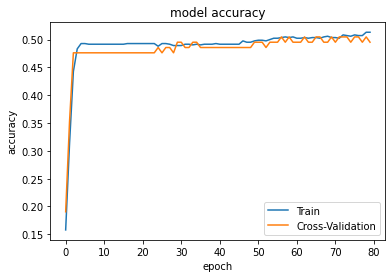

In [183]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='lower right')
plt.show()

# Model 2
# Neural Network with Two Hidden Layers

*   Input Layer: 29 features
*   Layer 1: 15 neurons, tanh activation
*   Layer 2: 15 neurons, relu activation
*   Output Layer: 5 Classes, softmax activation

In [188]:
tf.random.set_seed(5)

network2 = tf.keras.models.Sequential()
network2.add(tf.keras.Input(shape=(29,)))
network2.add(tf.keras.layers.Dense(15, activation='tanh'))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(5, activation='softmax'))

network2.compile(
   loss=tf.keras.losses.CategoricalCrossentropy(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics="accuracy")

history2 = network2.fit(train_features, train_target, epochs=40,validation_data=(validate_features,validate_target))

Epoch 1/40
27/27 [==============================] - 1s 15ms/step - loss: 1.6214 - accuracy: 0.1471 - val_loss: 1.6053 - val_accuracy: 0.3238
Epoch 2/40
27/27 [==============================] - 0s 5ms/step - loss: 1.5425 - accuracy: 0.4569 - val_loss: 1.5451 - val_accuracy: 0.4667
Epoch 3/40
27/27 [==============================] - 0s 5ms/step - loss: 1.4751 - accuracy: 0.4880 - val_loss: 1.4925 - val_accuracy: 0.4762
Epoch 4/40
27/27 [==============================] - 0s 5ms/step - loss: 1.4244 - accuracy: 0.4916 - val_loss: 1.4525 - val_accuracy: 0.4762
Epoch 5/40
27/27 [==============================] - 0s 5ms/step - loss: 1.3864 - accuracy: 0.4916 - val_loss: 1.4276 - val_accuracy: 0.4762
Epoch 6/40
27/27 [==============================] - 0s 5ms/step - loss: 1.3656 - accuracy: 0.4916 - val_loss: 1.4146 - val_accuracy: 0.4762
Epoch 7/40
27/27 [==============================] - 0s 7ms/step - loss: 1.3554 - accuracy: 0.4916 - val_loss: 1.4079 - val_accuracy: 0.4762
Epoch 8/40
27/27 [=

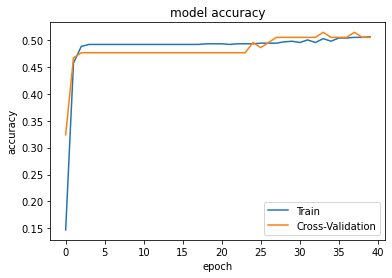

In [189]:
from matplotlib import pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='lower right')
plt.show()

# Model 3
# Neural Network with Three Hidden Layers

*   Input Layer: 29 features
*   Layer 1: 15 neurons, tanh activation
*   Layer 2: 15 neurons, relu activation
*   Layer 3: 10 neurons, relu activation
*   Output Layer: 5 Classes, softmax activation




In [196]:
tf.random.set_seed(5)

network3 = tf.keras.models.Sequential()
network3.add(tf.keras.Input(shape=(29,)))
network3.add(tf.keras.layers.Dense(15, activation='tanh'))
network3.add(tf.keras.layers.Dense(15, activation='relu'))
network3.add(tf.keras.layers.Dense(10, activation='relu'))
network3.add(tf.keras.layers.Dense(5, activation='softmax'))

network3.compile(
   loss=tf.keras.losses.CategoricalCrossentropy(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics="accuracy")

history3 = network3.fit(train_features, train_target, epochs=70
                       ,validation_data=(validate_features,validate_target))

Epoch 1/70
27/27 [==============================] - 1s 11ms/step - loss: 1.5735 - accuracy: 0.2404 - val_loss: 1.5237 - val_accuracy: 0.4571
Epoch 2/70
27/27 [==============================] - 0s 4ms/step - loss: 1.4885 - accuracy: 0.4916 - val_loss: 1.4591 - val_accuracy: 0.4762
Epoch 3/70
27/27 [==============================] - 0s 4ms/step - loss: 1.4269 - accuracy: 0.4916 - val_loss: 1.4231 - val_accuracy: 0.4762
Epoch 4/70
27/27 [==============================] - 0s 3ms/step - loss: 1.3933 - accuracy: 0.4916 - val_loss: 1.4068 - val_accuracy: 0.4762
Epoch 5/70
27/27 [==============================] - 0s 3ms/step - loss: 1.3674 - accuracy: 0.4916 - val_loss: 1.3984 - val_accuracy: 0.4762
Epoch 6/70
27/27 [==============================] - 0s 4ms/step - loss: 1.3526 - accuracy: 0.4916 - val_loss: 1.3963 - val_accuracy: 0.4762
Epoch 7/70
27/27 [==============================] - 0s 5ms/step - loss: 1.3457 - accuracy: 0.4916 - val_loss: 1.3966 - val_accuracy: 0.4762
Epoch 8/70
27/27 [=

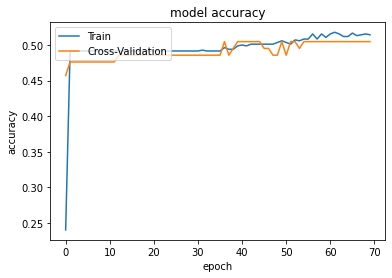

In [197]:
from matplotlib import pyplot as plt
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()

# Model 4
# Neural Network with Three Hidden Layers

*   Input Layer: 29 features
*   Layer 1: 15 neurons, tanh activation
*   Layer 2: 15 neurons, relu activation
*   Layer 3: 10 neurons, relu activation
*   Output Layer: 5 Classes, softmax activation


In [200]:
tf.random.set_seed(5)

network4 = tf.keras.models.Sequential()
network4.add(tf.keras.Input(shape=(29,)))
network4.add(tf.keras.layers.Dense(10, activation='relu'))
network4.add(tf.keras.layers.Dense(10, activation='relu'))
network4.add(tf.keras.layers.Dense(10, activation='relu'))
network4.add(tf.keras.layers.Dense(5, activation='softmax'))

network4.compile(
   loss=tf.keras.losses.CategoricalCrossentropy(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics="accuracy")

history4 = network4.fit(train_features, train_target, epochs=55
                       ,validation_data=(validate_features,validate_target))

Epoch 1/55
27/27 [==============================] - 2s 30ms/step - loss: 1.5946 - accuracy: 0.1364 - val_loss: 1.5679 - val_accuracy: 0.3333
Epoch 2/55
27/27 [==============================] - 0s 8ms/step - loss: 1.5421 - accuracy: 0.4294 - val_loss: 1.5275 - val_accuracy: 0.4667
Epoch 3/55
27/27 [==============================] - 0s 8ms/step - loss: 1.4985 - accuracy: 0.4904 - val_loss: 1.4830 - val_accuracy: 0.4762
Epoch 4/55
27/27 [==============================] - 0s 8ms/step - loss: 1.4529 - accuracy: 0.4916 - val_loss: 1.4420 - val_accuracy: 0.4762
Epoch 5/55
27/27 [==============================] - 0s 9ms/step - loss: 1.4110 - accuracy: 0.4916 - val_loss: 1.4174 - val_accuracy: 0.4762
Epoch 6/55
27/27 [==============================] - 0s 5ms/step - loss: 1.3821 - accuracy: 0.4916 - val_loss: 1.4056 - val_accuracy: 0.4762
Epoch 7/55
27/27 [==============================] - 0s 7ms/step - loss: 1.3675 - accuracy: 0.4916 - val_loss: 1.4020 - val_accuracy: 0.4762
Epoch 8/55
27/27 [=

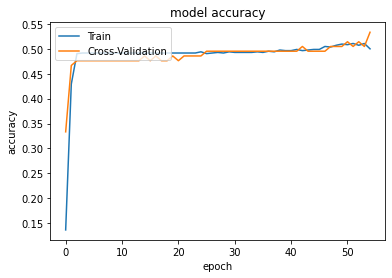

In [201]:
from matplotlib import pyplot as plt
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()